# 📘 Notebook: 03_random_forest_regressor.ipynb
_**Part of the Fragma IPython Notebook Project Series**_

*Focused on developing and evaluating machine learning models for fragment detection.*

---

## 🧭 Table of Contents

1. [📘 Overview & Navigation](#overview)
2. [🧠 Context & Purpose](#context)
3. [🧩 Main Components](#components)
4. [🧭 Notebook Structure](#notebooks)
5. [📦 Dependencies](#dependencies)
6. [🛠️ Config & Setup](#setup)
7. [📊 Model Pipeline](#pipeline)
8. [📈 Evaluation & Results](#results)
9. [📚 Resources](#resources)
10. [👥 Contributors](#team)

> **Quick Links:** [🏠 Home](#overview) | [🔄 Status](#notebooks) | [📚 Docs](#resources)

---

## 🧪 Overview & Navigation

This notebook represents the final stage in our fragment detection pipeline, focusing on model development and evaluation.
It provides: **A comprehensive machine learning pipeline using TF-IDF vectorization, Random Forest classification, and PSO-based hyperparameter optimization.**

---

## 🧠 Context & Purpose

**🎯 Purpose:**  
To develop and evaluate a robust machine learning model for detecting sentence fragments, combining both text-based and structural features.

**🎯 Objectives:**  
- Develop an effective text vectorization strategy
- Build a hybrid model combining text and structural features
- Optimize model performance using PSO
- Evaluate and analyze model performance
- Visualize feature importance and results

**📘 Context:**  
This notebook builds upon the preprocessed data from notebook 02, utilizing both the cleaned text and extracted linguistic features to create a powerful fragment detection model.

## 🧩 Main Components

### `TextVectorizer`
> TF-IDF based text vectorization with optimized parameters.

```python
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
# Returns: Sparse matrix of TF-IDF features
```

### `ModelPipeline`
> Comprehensive pipeline combining text and structural features.

```python
pipeline = Pipeline([
    ('features', ColumnTransformer([
        ('text', TfidfVectorizer(), text_col),
        ('struct', 'passthrough', structured_cols)
    ])),
    ('classifier', RandomForestClassifier())
])
```

### `PSOOptimizer`
> Particle Swarm Optimization for hyperparameter tuning.

```python
best_params = optimize_hyperparameters(pipeline, param_space)
# Returns: Optimized hyperparameters with cross-validation
```

## 📦 Dependencies

```bash
pandas         # Data manipulation
numpy         # Numerical operations
scikit-learn  # Machine learning tools
pyswarms      # PSO implementation
matplotlib    # Visualization
seaborn      # Enhanced visualization
colab_print  # Pretty printing for colab
```

### Installation and Import

In [ ]:
!pip install kagglehub pandas numpy tqdm matplotlib seaborn nltk scikit-learn ftfy contractions emoji textblob
!pip install -U colab_print # Always use last version

In [ ]:

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score,train_test_split
import seaborn as sns
from  matplotlib import pyplot as plt
import os
import re
import pandas as pd
import subprocess
import random
from colab_print import Printer, header, list_, table, dfd, info, error, success, warning, title
from tqdm.auto import tqdm
import nltk
import shutil
from typing import List, Optional, Dict, Tuple, Any, Union, Literal

## 🛠️ Config / Setup
- ### Helper and Utility Functions
- ### Paths, Constants and etc.
```python
URL = "tomthescientist/netflix-facebook-posts-as-sentences-for-llm-input"
DSPATH = os.path.join(download_ds(URL), "netflix_fb_sentences.csv")
EXPANDPATH = 'expanded_dataset.csv'
EXPANDPATH_URL = "url"
PROCESSEDPATH = 'processed_dataset.csv'
PROCESSEDPATH_URL = 'url'
```

In [ ]:
def download_ds(url):
  import kagglehub

  # Download latest version
  path = kagglehub.dataset_download(url)

  print("Path to dataset files:", path)
  return path

def mount_drive():
  from google.colab import drive
  """Uploads the dataset_fragments.csv file to Google Drive."""
  drive.mount('/content/drive')

def move_to_nlp_drive(file, path):
  if not os.path.exists(path):
    raise ValueError("Path does not exist")

  shutil.move(file, path)

def safe_download_nltk_resources():
    packages = ['stopwords', 'punkt', "punkt_tab"]
    for package in tqdm(packages, unit="pak", desc="Downloading resources", leave=True):
        try:
            nltk.download(package, quiet=True)
        except Exception as e:
            print(f"Failed to download {package}: {e}")

def count_fragments(df):
    count_t = df['is_fragment'].sum() # True Count
    count_f = len(df) - count_t # False Count
    return count_t, count_f

def get_df(path, **kwargs):
  return pd.read_csv(path, **kwargs)

def sync_colab_workspace(files: list, sync_strategy: Literal["clone", "upload", "copy"] = "copy", **kwargs):
    """Ensure all modules and files exist in Google Colab."""
    from google.colab import files, drive

    script_files = files

    if sync_strategy == "copy":
        drive_path = "/content/drive"
        if not os.path.exists(drive_path):
            drive.mount()

        nlp_project_path = kwargs.get("nlp")

        for file in tqdm(script_files, leave=False):
            src = os.path.join(nlp_project_path, file)
            dst = os.path.join("/content", file)
            if os.path.exists(src):
                shutil.copy(src, dst)
            else:
                warning(f"Warning: {file} not found in Drive path.")

    elif sync_strategy == "upload":
        uploaded = files.upload()
        for name in uploaded.keys():
            success(f"Uploaded: {name}")

    elif sync_strategy == "clone":
        repo_url = kwargs.get("repo_url")
        project_name = kwargs.get("project_name")

        repo_dir = f"/content/{project_name}"
        if os.path.exists(repo_dir):
            shutil.rmtree(repo_dir)
        subprocess.run(["git", "clone", repo_url], check=True)

        for file in script_files:
            src = os.path.join(repo_dir, file)
            dst = os.path.join("/content", file)
            if os.path.exists(src):
                shutil.copy(src, dst)
            else:
                warning(f"Warning: {file} not found in cloned repo.")

    else:
        raise ValueError("Invalid sync_strategy. Choose from 'copy', 'upload', or 'clone'.")

    def verify_files():
        print("\nVerifying required files in /content:")
        missing = []
        for file in script_files:
            if not os.path.exists(os.path.join("/content", file)):
                missing.append(file)
        if missing:
            print("Missing files:", missing)
        else:
            print("✅ All files are present.")

    verify_files()

def download_gist_file(raw_url, output):
  import requests

  output_filename = output

  # Perform the download
  response = requests.get(raw_url)

  # Check if the request was successful
  if response.status_code == 200:
      with open(output_filename, 'wb') as f:
          f.write(response.content)
      print(f"Gist file downloaded successfully as '{output_filename}'")
  else:
      print(f"Failed to download file. Status code: {response.status_code}")


def check_nltk_resources():
    resources = {
        'stopwords': 'corpora/stopwords',
        'punkt': 'tokenizers/punkt'
    }

    for name, path in tqdm(resources.items(), unit="resource", desc="Checking resources", leave=True):
        try:
            nltk.data.find(path)
            print(f"[✓] {name} is available.")
        except LookupError:
            print(f"[✗] {name} is NOT available.")

In [ ]:
URL = "tomthescientist/netflix-facebook-posts-as-sentences-for-llm-input"
PROJECT_URL = "https://github.com/alaamer12/Fragma"
PROJECT_NAME = "Fragma"
NLP_PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/College/3rd Level 2nd Term/Natural Language Processing/Project"
FILENAME = "netflix_fb_sentences.csv"

DSPATH  = os.path.join(download_ds(URL), FILENAME)
FDPATH = 'dataset_fragments.csv'

EXPANDPATH = 'expanded_dataset.csv'
EXPANDPATH_URL = "https://gist.githubusercontent.com/alaamer12/49c5d930b52f189d7fd195ca8c66b7d1/raw"

PROCESSEDPATH = 'processed_dataset.csv'
PROCESSEDPATH_URL = "https://gist.githubusercontent.com/alaamer12/49c5d930b52f189d7fd195ca8c66b7d1/raw/68cdd6fca9709247a9d497a4f7102f42bef4d040/processed_dataset.csv"

STRATEGY = 'expand'
BALANCE_PER = "95%"
TOLERANCE = "0.1%"

SCRIPT_FILES = [
        "fd_dataset_creator_script.py",
        "fd_ds_expander.py",
        "fd_linguistic_features.py",
        "preprocessor.py",
        "README.md",
        "FD.md",
    ]



DEFAULT_PREPROCESSING_CONFIG = {
    "fix_unicode": True,
    "remove_invalid": True,
    "normalize_whitespace": True,
    "remove_emojis": True,
    "lowercase": True,
    "normalize_words": True,
    "expand_contractions": True,
    "normalize_punctuation": True,
    "strip_platform_noise": True,
    "remove_stopwords": True, # Optional step
    "tokenize": False,         # Optional step (returns list if True)
    "keep_punctuation_tokens": False, # Only if tokenize is True
    "spell_correct": False     # Optional step (expensive)
}

safe_download_nltk_resources()
check_nltk_resources()
download_gist_file(PROCESSEDPATH_URL, PROCESSEDPATH)

# SYNC_STRATEGY = "copy"
# sync_colab_workspace(SCRIPT_FILES, SYNC_STRATEGY) # Dont forget to send kwargs for each strategy
df = pd.read_csv('processed_dataset.csv')

Gist file downloaded successfully as 'processed_dataset.csv'


## 🧭 Notebook Structure

| 🔢 Order | 📓 Notebook | 📝 Description |
|---------:|------------|----------------|
| 0 | [00-Fragma-Overview.ipynb](https://colab.research.google.com/drive/1oUmSqBuPqv2gObJjhezXaa6xBxe_Tl4g?usp=sharing) | Project overview and setup |
| 1 | [01-Fragment-DS-Generator.ipynb](https://colab.research.google.com/drive/1aAVCptdYyRHmytnY7O__anYKpZh5Hl-w?usp=sharing) | Dataset generation |
| 2 | [02-Data-Preprocessing.ipynb](https://colab.research.google.com/drive/1QbVTz71jGvVvr2rXwJk9RKGKS4r1ntCC?usp=sharing) | Text preprocessing |
| 3 | [03-Model-Development.ipynb](https://colab.research.google.com/drive/1CDwjXuqBj1LBdXXvvFymNh6etWNpUnth?usp=sharing) | Model training and evaluation (Current) |

> ⏮ **Previous:** [02-Data-Preprocessing.ipynb](https://colab.research.google.com/drive/1QbVTz71jGvVvr2rXwJk9RKGKS4r1ntCC?usp=sharing)

## 📥 Inputs & Outputs

**📥 Inputs:**
- `processed_dataset.csv`: Preprocessed dataset with text and linguistic features
  - Text column: 'Processed Text'
  - Target column: 'is_fragment'
  - Structural features: 17 binary linguistic markers

**📤 Outputs:**
- Trained model with:
  - Optimized TF-IDF vectorizer
  - Tuned Random Forest classifier
  - Feature importance rankings
  - Performance metrics and visualizations
  - Detailed error analysis

## 📊 Exploratory Data Analysis (EDA)

Look for trends, distributions, and outliers.


🔍 DataFrame shape: (45341, 20)
🧾 First 5 rows:
                                    Sentence Fragment  is_fragment  \
0         Why isn't everyone talking about Daybreak?        False   
1   The CGI in Tiny Pretty Things is groundbreaking.        False   
2  The characters in Gentefied are wonderfully de...        False   
3  I wish the supporting character from Ragnarok ...        False   
4  Netflix really knows how to tell a story with ...        False   

   has_auxiliary  has_fullstop  has_question_mark  has_exclamation_mark  \
0          False         False               True                 False   
1           True          True              False                 False   
2           True          True              False                 False   
3           True          True              False                 False   
4          False          True              False                 False   

   has_comma  has_semicolon  has_colon  has_quotation  has_expression  \
0      False 

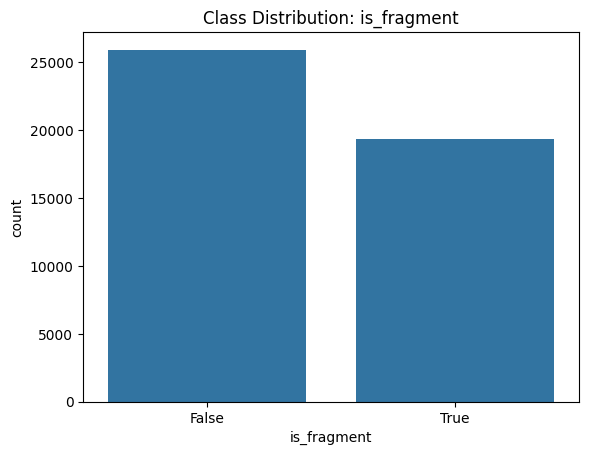


📊 Descriptive statistics:
                        Sentence Fragment is_fragment has_auxiliary  \
count                              45341       45341         45341   
unique                             45341           2             2   
top     for season three of The Sandman?       False          True   
freq                                   1       25951         28665   

       has_fullstop has_question_mark has_exclamation_mark has_comma  \
count         45341             45341                45341     45341   
unique            2                 2                    2         1   
top            True             False                False     False   
freq          38139             39522                44237     45341   

       has_semicolon has_colon has_quotation has_expression has_conjunction  \
count          45341     45341         45341          45341           45341   
unique             1         2             2              2               2   
top            False   

In [ ]:
# 1. Show basic structure
print("🔍 DataFrame shape:", df.shape)
print("🧾 First 5 rows:\n", df.head())

# 2. Check for missing values
print("\n🚨 Missing values:\n", df.isnull().sum())

# 3. Target variable distribution
print("\n🎯 Target distribution (is_fragment):\n", df["is_fragment"].value_counts())

# 4 Visualize target balance
sns.countplot(data=df, x="is_fragment")
plt.title("Class Distribution: is_fragment")
plt.show()

# 5. Basic statistics for numeric columns
print("\n📊 Descriptive statistics:\n", df.describe())


## 🛠️ Data Preprocessing

Clean, transform, and prepare the dataset for modeling.

In [ ]:
#preprocessing encode boolean values to numerical to be safer and more consistent
df.replace({True: 1, False: 0})

<ipython-input-6-93ef37141812>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0})


,Sentence Fragment,is_fragment,has_auxiliary,has_fullstop,has_question_mark,has_exclamation_mark,has_comma,has_semicolon,has_colon,has_quotation,has_expression,has_conjunction,has_temporal,has_opinion_adverb,has_adverb,has_starter,has_past_verb,has_gerund,starts_capitalized,Processed Text
0,Why isn't everyone talking about Daybreak?,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,everyone talking daybreak
1,The CGI in Tiny Pretty Things is groundbreaking.,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,cgi tiny pretty things groundbreaking
2,The characters in Gentefied are wonderfully de...,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,characters gentefied wonderfully developed
3,I wish the supporting character from Ragnarok ...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,wish supporting character ragnarok screen time
4,Netflix really knows how to tell a story with ...,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,netflix really knows tell story last kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45336,Netflix's original content like Warrior Nun is...,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,netflix 's original content like warrior nun b...
45337,episode of Locke & Key was instantly hooked.,1,1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,episode locke key instantly hooked
45338,outdid themselves with 13 Reasons Why.,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,outdid 13 reasons
45339,Vikings: Valhalla make me feel anxious?,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,vikings valhalla make feel anxious


In [ ]:
X = df.drop(columns=["Sentence Fragment", "is_fragment"])
y = df["is_fragment"]

## Pipeline

In [ ]:
# structured features
structured_features = ['has_fullstop', 'has_question_mark', 'has_auxiliary','has_exclamation_mark','has_semicolon','has_quotation']

# preprocessing step
preprocessor = ColumnTransformer([
    ('text', TfidfVectorizer(ngram_range=(1,2)), 'Processed Text'),
    ('struct', 'passthrough', structured_features)
])

# Create pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=68))
])

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=68)
# Fill missing values (required before fitting)
X['Processed Text'] = X['Processed Text'].fillna('')
X[structured_features] = X[structured_features].fillna(0)
# Perform cross-validation and get scores
cv_scores =  cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy', error_score='raise')

# Print results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")


Cross-validation scores: [0.91917521 0.92059991 0.9221438  0.91784296 0.91993824]
Mean accuracy: 0.9199 (±0.0014)


## PSO

In [ ]:

from dataclasses import dataclass
from typing import Tuple , List, Callable
import numpy as np
import random
from  matplotlib import pyplot as plt

@dataclass
class AlgConfig:
    """Base class for algorithm configuration"""
    def __post_init__(self) -> None:
        pass

@dataclass
class PSOConfig(AlgConfig):
    objective_function: Callable[[List[float]], float]
    bounds: List[tuple[float, float]]
    n_dimensions: int = None
    n_particles: int = 30
    iterations: int = 100
    w: float = 0.5
    c1: float = 1.5
    c2: float = 1.5

    def __post_init__(self) -> None:
        super().__post_init__()
        if self.n_dimensions is None:
            self.n_dimensions = len(self.bounds)


class Particle:
    """
    Particle in the PSO algorithm.

    Each particle has a position, velocity, and memory of its best position.
    """
    def __init__(self, bounds: List[Tuple[float, float]], n_dimensions: int):

        self.position = [random.uniform(bounds[i][0], bounds[i][1]) for i in range(n_dimensions)]


        self.velocity = [random.uniform(-1, 1) for _ in range(n_dimensions)]


        self.best_position = self.position.copy()
        self.best_fitness = float('inf')
        self.current_fitness = float('inf')

    def update_velocity(self, global_best_position: List[float], w: float, c1: float, c2: float) -> None:
        """Update the velocity of the particle"""
        for i in range(len(self.velocity)):
            # Inertia component
            inertia = w * self.velocity[i]

            # Cognitive component (personal best)
            r1 = random.random()
            cognitive = c1 * r1 * (self.best_position[i] - self.position[i])

            # Social component (global best)
            r2 = random.random()
            social = c2 * r2 * (global_best_position[i] - self.position[i])

            # Update velocity
            self.velocity[i] = inertia + cognitive + social

    def update_position(self, bounds: List[Tuple[float, float]]) -> None:
        """Update the position of the particle and handle boundary conditions"""
        for i in range(len(self.position)):
            # Update position
            self.position[i] += self.velocity[i]

            if self.position[i] < bounds[i][0]:
                self.position[i] = bounds[i][0]
                self.velocity[i] *= -0.5  # Bounce back with reduced velocity
            elif self.position[i] > bounds[i][1]:
                self.position[i] = bounds[i][1]
                self.velocity[i] *= -0.5  # Bounce back with reduced velocity

    def evaluate(self, objective_function: Callable[[List[float]], float]) -> float:
        """Evaluate the particle's current position and update best if improved"""
        self.current_fitness = objective_function(self.position)

        # Update personal best if current position is better
        if self.current_fitness < self.best_fitness:
            self.best_fitness = self.current_fitness
            self.best_position = self.position.copy()

        return self.current_fitness


class ParticleSwarmOptimization:
    """
    Main PSO algorithm implementation.

    Manages the swarm of particles and the optimization process.
    """
    def __init__(self, config: PSOConfig):
        self.config = config
        self.particles = []
        self.global_best_position = None
        self.global_best_fitness = float('inf')
        self.fitness_history = []
        self.avg_fitness_history = []


        for _ in range(config.n_particles):
            self.particles.append(Particle(config.bounds, config.n_dimensions))

    def optimize(self) -> Tuple[List[float], float, List[float], List[float]]:
        """Run the optimization algorithm"""

        for particle in self.particles:
            fitness = particle.evaluate(self.config.objective_function)

            # Update global best if this particle is better
            if fitness < self.global_best_fitness:
                self.global_best_fitness = fitness
                self.global_best_position = particle.position.copy()

        # Main optimization loop
        for i in range(self.config.iterations):
            current_best_fitness = self.global_best_fitness
            total_fitness = 0


            for particle in self.particles:
                particle.update_velocity(
                    self.global_best_position,
                    self.config.w,
                    self.config.c1,
                    self.config.c2
                )
                particle.update_position(self.config.bounds)

                fitness = particle.evaluate(self.config.objective_function)
                total_fitness += fitness


                if fitness < self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best_position = particle.position.copy()


            self.fitness_history.append(self.global_best_fitness)
            self.avg_fitness_history.append(total_fitness / len(self.particles))



        return (
            self.global_best_position,
            self.global_best_fitness,
            self.fitness_history,
            self.avg_fitness_history
        )


# Visualization functions
def plot_convergence(fitness_history, avg_fitness_history=None, title="PSO Convergence"):
    """Plot the convergence of the PSO algorithm"""
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history, 'b-', linewidth=2, label='Global Best Fitness')
    if avg_fitness_history:
        plt.plot(avg_fitness_history, 'r--', linewidth=1, label='Average Swarm Fitness')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Use log scale for better visualization
    plt.show()


In [ ]:
def optimize_random_forest_classification():
    print("Starting Random Forest Classification Hyperparameter Optimization...")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the objective function for PSO
    def objective_function(params):
        # Extract parameters and convert to appropriate types
        n_estimators = int(params[0])
        max_depth = int(params[1]) if params[1] > 0 else None
        min_samples_split = int(params[2])
        min_samples_leaf = int(params[3])

        # Create Random Forest model
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

        # Use cross-validation to evaluate the model
        try:
            scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')
            # We want to maximize accuracy, but PSO minimizes, so return negative accuracy
            return -np.mean(scores)
        except Exception as e:
            # Return a high value in case of errors
            print(f"Error in evaluation: {e}")
            return 0


    bounds = [(10, 200), (0, 30), (2, 20), (1, 10)]

    # Create PSO config and initialize optimizer
    config = PSOConfig(
        objective_function=objective_function,
        bounds=bounds,
        n_particles=20,
        iterations=50,
        w=0.5,
        c1=1.5,
        c2=1.5
    )
    pso = ParticleSwarmOptimization(config)

    # Run optimization
    best_params, best_fitness, fitness_history, avg_fitness_history = pso.optimize()

    # Convert parameters to appropriate types
    best_n_estimators = int(best_params[0])
    best_max_depth = int(best_params[1]) if best_params[1] > 0 else None
    best_min_samples_split = int(best_params[2])
    best_min_samples_leaf = int(best_params[3])

    print(f"Best Parameters:")
    print(f"  n_estimators: {best_n_estimators}")
    print(f"  max_depth: {best_max_depth}")
    print(f"  min_samples_split: {best_min_samples_split}")
    print(f"  min_samples_leaf: {best_min_samples_leaf}")
    print(f"Best Fitness (negative accuracy): {best_fitness}")

    # Train final model with best parameters
    final_model = RandomForestClassifier(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_split=best_min_samples_split,
        min_samples_leaf=best_min_samples_leaf,
        random_state=42
    )
    final_model.fit(X_train, y_train)

    # Evaluate on test set
    accuracy = final_model.score(X_test, y_test)
    print(f"Test Accuracy with Best Parameters: {accuracy:.4f}")

    # Plot convergence
    plot_convergence(fitness_history, avg_fitness_history)

    return best_params, best_fitness

In [ ]:
best_params, best_fitness = optimize_random_forest_classification()
print(best_params,best_fitness)

## 👥 Contributors

| 👤 Name | 🧑‍💻 Role | 📬 GitHub | 🔗 LinkedIn |
|---------|----------|-----------|------------|
| Amr Muhamed | Maintainer | [alaamer12](https://github.com/alaamer12) | [alaamer12](https://linkedin.com/in/alaamer12) |
| Muhamed Ibrahim | Data Engineer | [muhammad-senna](https://github.com/muhammad-senna) | [muhammad-senna](https://linkedin.com/in/muhammad-senna) |

© 2025 Amr Muhamed. All Rights Reserved.

*Last updated: May 13, 2025*